In [2]:
!pip install qulacs mpi4py numpy matplotlib

# **READ.ME** ❗❗

❗❗ The purpose of this notebook is to show the code of the scripts used (without all the modifications that were made during the multiple tests). In addition we also show the results of all the tests performed and the whole process of generating the graphs.

---

# **SCRIPTS**

# file_to_send_qmio_optim.py

In [3]:
from qulacs import QuantumState, QuantumCircuit, Observable
from qulacs.gate import RX, RY, RZ, CNOT, DenseMatrix
import numpy as np
import time
from mpi4py import MPI
import matplotlib.pyplot as plt

# Circuit part

In [8]:
def qc_autoenc(num_qubits):
    num_layers = 2
    qc = QuantumCircuit(num_qubits)

    # Capa inicial de rotaciones
    for i in range(num_qubits):
        angle_x = 2*np.pi/(1*(i+1))
        angle_y = 2*np.pi/(2*(i+1))
        qc.add_gate(RX(i, angle_x))
        qc.add_gate(RY(i, angle_y))

    # Capas entrelazadas
    for l in range(num_layers):
        # Entrelazamiento
        for i in range(num_qubits):
            for j in range(i+1, num_qubits):
                qc.add_gate(CNOT(i, j))

        # Rotaciones parametrizadas
        for i in range(num_qubits):
            angle_x = 2*np.pi*(l+1)/(3*(i+1))
            angle_y = 2*np.pi*(l+1)/(4*(i+1))
            angle_z = 2*np.pi*(l+1)/(5*(i+1))
            qc.add_gate(RX(i, angle_x))
            qc.add_gate(RY(i, angle_y))
            qc.add_gate(RZ(i, angle_z))

    # Capa final de rotaciones inversas
    for i in range(num_qubits):
        angle_y = -2*np.pi/(2*(i+1))
        angle_x = -2*np.pi/(1*(i+1))
        qc.add_gate(RY(i, angle_y))
        qc.add_gate(RX(i, angle_x))

    return qc

# StateVector generation

In [ ]:
def run_simulation(num_qubits, comm): #vector de estados
    # Crear el circuito
    circuit = qc_autoenc(num_qubits)

    # Crear el estado cuántico
    state = QuantumState(num_qubits)
    state.set_zero_state()

    # Ejecutar el circuito
    start_time = time.time()
    circuit.update_quantum_state(state)
    end_time = time.time()

    # Calcular el tiempo de ejecución
    execution_time = end_time - start_time

    # Recopilar tiempos de todos los procesos
    all_times = comm.gather(execution_time, root=0)

    if comm.rank == 0:
        # Calcular estadísticas
        mean_time = np.mean(all_times)
        median_time = np.median(all_times)
        std_time = np.var(all_times)
        return mean_time, median_time, std_time
    else:
        return None, None, None

In [ ]:

def main():
    # Inicializar MPI
    comm = MPI.COMM_WORLD
    rank = comm.rank

    range_qubits = 25
    repetitions = 20

    time_statevector_mean = []
    time_statevector_median = []
    time_statevector_std = []

    if rank == 0:
        qubits_list = list(range(1, range_qubits+1))
    else:
        qubits_list = None

    # Distribuir la lista de qubits a todos los procesos
    qubits_list = comm.bcast(qubits_list, root=0)

    for num_qubits in qubits_list:
        if rank == 0:
            print(f"Procesando {num_qubits} qubits...")

        # Ejecutar múltiples repeticiones
        all_means = []
        all_medians = []
        all_stds = []

        for _ in range(repetitions):
            mean, median, std = run_simulation(num_qubits, comm)
            if rank == 0:
                all_means.append(mean)
                all_medians.append(median)
                all_stds.append(std)

        if rank == 0:
            # Promediar los resultados de las repeticiones
            final_mean = np.mean(all_means)
            final_median = np.mean(all_medians)
            final_std = np.mean(all_stds)

            time_statevector_mean.append(final_mean)
            time_statevector_median.append(final_median)
            time_statevector_std.append(final_std)

    if rank == 0:
        # Imprimir resultados
        print("Medias:", time_statevector_mean)
        print("Medianas:", time_statevector_median)
        print("Desviaciones estándar:", time_statevector_std)

        # Graficar resultados
        #plt.figure(figsize=(8, 5))
        #plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
        #plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
        #plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std,
        #            fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

        #plt.xlabel('Número de Qubits')
        #plt.ylabel('Tiempo de ejecución (s)')
        #plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
        #plt.legend()
        #plt.grid(True, linestyle='--', alpha=0.7)
        #plt.savefig('quantum_autoencoder_performance.png')
        #plt.show()

if __name__ == "__main__":
    main()

# Circuit measurement

In [9]:

def simulate_with_shots(qc, shots=2048):
    """Simula el circuito y realiza mediciones (equivalentes a shots en Qiskit)"""
    num_qubits = qc.get_qubit_count()
    state = QuantumState(num_qubits)
    state.set_zero_state()

    # Ejecutar el circuito
    qc.update_quantum_state(state)

    # Realizar mediciones
    counts = {}
    for _ in range(shots):
        # Obtener el vector de estado completo
        state_vector = state.get_vector()

        # Calcular probabilidades para cada estado base
        probabilities = np.abs(state_vector)**2

        # Muestrear un resultado basado en las probabilidades
        outcome_idx = np.random.choice(len(state_vector), p=probabilities)
        outcome_str = format(outcome_idx, f'0{num_qubits}b')[::-1]  # Binario, qubit 0 es el LSB

        counts[outcome_str] = counts.get(outcome_str, 0) + 1

    return counts

def run_simulation_2(num_qubits, shots=2048, comm=None):
    qc = qc_autoenc(num_qubits)

    start_time = time.time()
    counts = simulate_with_shots(qc, shots)
    end_time = time.time()

    execution_time = end_time - start_time

    if comm is not None:
        all_times = comm.gather(execution_time, root=0)

        if comm.rank == 0:
            mean_time = np.mean(all_times)
            median_time = np.median(all_times)
            std_time = np.std(all_times)
            return mean_time, median_time, std_time
        else:
            return None, None, None
    else:
        return execution_time, execution_time, 0.0

In [ ]:
def main_2():
    comm = MPI.COMM_WORLD
    rank = comm.rank

    range_qubits = 25
    repetitions = 20
    shots = 2048

    time_run_mean = []
    time_run_median = []
    time_run_std = []

    if rank == 0:
        qubits_list = list(range(1, range_qubits+1))
    else:
        qubits_list = None

    qubits_list = comm.bcast(qubits_list, root=0)

    for num_qubits in qubits_list:
        if rank == 0:
            print(f"Procesando {num_qubits} qubits...")

        all_means = []
        all_medians = []
        all_stds = []

        for _ in range(repetitions):
            mean, median, std = run_simulation_2(num_qubits, shots, comm)
            if rank == 0:
                all_means.append(mean)
                all_medians.append(median)
                all_stds.append(std)

        if rank == 0:
            final_mean = np.mean(all_means)
            final_median = np.mean(all_medians)
            final_std = np.mean(all_stds)

            time_run_mean.append(final_mean)
            time_run_median.append(final_median)
            time_run_std.append(final_std)

    if rank == 0:
        print("Medias:", time_run_mean)
        print("Medianas:", time_run_median)
        print("Desviaciones estándar:", time_run_std)

        qubits = list(range(1, range_qubits+1))

        #plt.figure(figsize=(8, 5))
        #plt.plot(qubits, time_run_mean, 'o-', label='Media', color='blue')
        #plt.plot(qubits, time_run_median, 's-', label='Mediana', color='green')
        #plt.errorbar(qubits, time_run_mean, yerr=time_run_std,
        #            fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

        #plt.xlabel('Número de Qubits')
        #plt.ylabel('Tiempo de ejecución (s)')
        #plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
        #plt.legend()
        #plt.grid(True, linestyle='--', alpha=0.7)
        #plt.savefig('quantum_autoencoder_performance_shots.png')
        #plt.show()

if __name__ == "__main__":
    main_2()


---

# run.sh

In [ ]:
#!/bin/bash
#SBATCH -p a64
#SBATCH -N 1 #numero de nodos.
#SBATCH --tasks-per-node=1 #numero de procesos MPI por nodo
#SBATCH -c 48 #numero cores
#SBATCH -t 48:0:0
#SBATCH --mem-per-cpu=625M
source /etc/profile.d/lmod.sh
module load qulacs-hpcx
export QULACS_NUM_THREADS=48
export GOMP_CPU_AFFINITY="0-47"
time mpirun python file_to_send_qmio_optim.py

---
---

# **TESTS**

# Run 1 10 qubits
## Vector estados

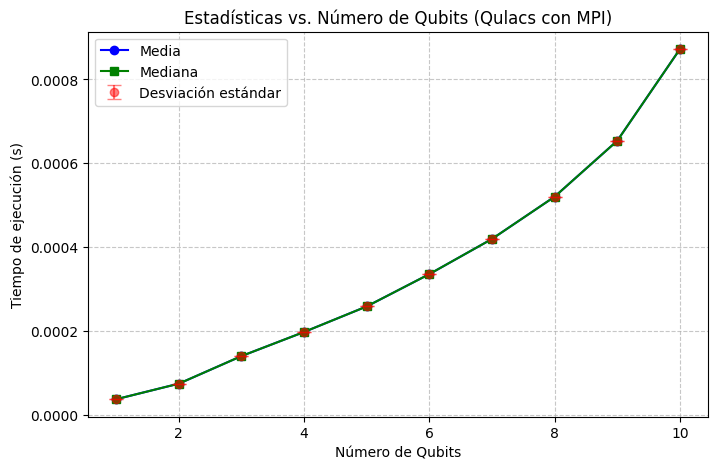

In [5]:
import matplotlib.pyplot as plt


qubits_list = list(range(1, 10+1))

time_statevector_mean = [3.6829710006713866e-05, 7.395148277282715e-05, 0.00013977885246276855, 0.0001973092555999756, 0.0002582967281341553, 0.0003354012966156006, 0.00041928887367248535, 0.0005201280117034912, 0.0006534755229949951, 0.0008720695972442627]

time_statevector_median = [3.6829710006713866e-05, 7.395148277282715e-05, 0.00013977885246276855, 0.0001973092555999756, 0.0002582967281341553, 0.0003354012966156006, 0.00041928887367248535, 0.0005201280117034912, 0.0006534755229949951, 0.0008720695972442627]

time_statevector_std =  [4.18509671362699e-13, 3.715427965289564e-12, 2.0250467969162855e-13, 2.248867758680717e-12, 3.361790845701762e-11, 5.468976382871915e-11, 8.966338782556705e-12, 2.078337502098293e-12, 1.0238210279567284e-11, 1.6396839441767952e-10]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()

## Medida de circuito

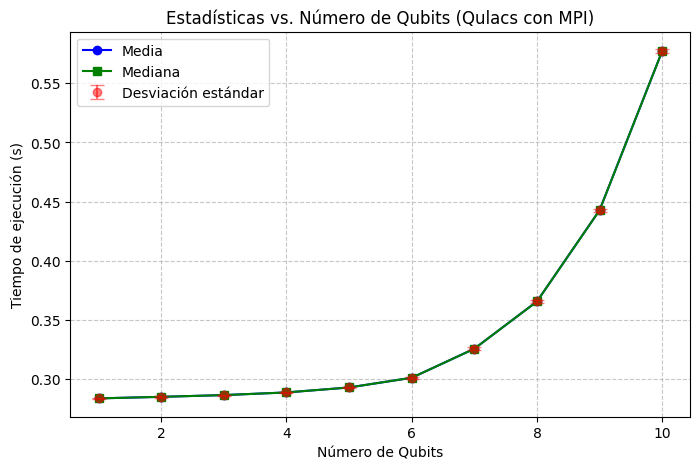

In [15]:
time_statevector_mean = [0.28386470079422, 0.28517472743988037, 0.2866419851779938, 0.2888800442218781, 0.29307584166526796, 0.30127058625221254, 0.32579444646835326, 0.36570305228233335, 0.44278091192245483, 0.5771552443504333]
time_statevector_median = [0.28386470079422, 0.28517472743988037, 0.2866419851779938, 0.2888800442218781, 0.29307584166526796, 0.30127058625221254, 0.32579444646835326, 0.36570305228233335, 0.44278091192245483, 0.5771552443504333]
time_statevector_std = [0.0007076740264892578, 0.0011099576950073242, 0.00039018988609313966, 0.0006860673427581787, 0.000642460584640503, 0.000620955228805542, 0.0012174367904663086, 0.0011783182621002198, 0.0013419032096862794, 0.001507413387298584]

qubits_list = list(range(1, 10+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()

# Run 1 25 qubits optim 2 nodosslurm-156360.out

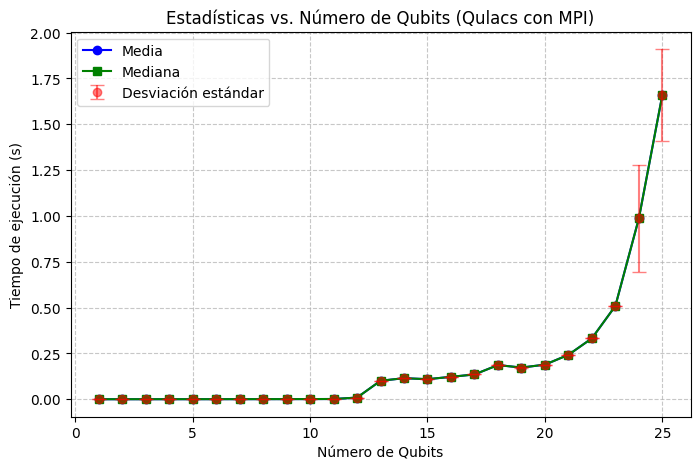

In [29]:
time_statevector_mean = [3.736019134521484e-05, 7.385611534118652e-05, 0.00014078617095947266, 0.00019723176956176758, 0.000258946418762207, 0.0003289461135864258, 0.00041960477828979493, 0.000525820255279541, 0.0006457746028900146, 0.0008644402027130127, 0.0012511193752288818, 0.008983379602432251, 0.10070460438728332, 0.1148019015789032, 0.10929279923439025, 0.1221742033958435, 0.13508762717247008, 0.18640466332435607, 0.17259765267372132, 0.18866763710975648, 0.24211345314979554, 0.3322013974189758, 0.50885871052742, 0.9862230300903321, 1.6597247540950775]
time_statevector_median = [3.736019134521484e-05, 7.385611534118652e-05, 0.00014078617095947266, 0.00019723176956176758, 0.000258946418762207, 0.0003289461135864258, 0.00041960477828979493, 0.000525820255279541, 0.0006457746028900146, 0.0008644402027130127, 0.0012511193752288818, 0.008983379602432251, 0.10070460438728332, 0.1148019015789032, 0.10929279923439025, 0.1221742033958435, 0.13508762717247008, 0.18640466332435607, 0.17259765267372132, 0.18866763710975648, 0.24211345314979554, 0.3322013974189758, 0.50885871052742, 0.9862230300903321, 1.6597247540950775]
time_statevector_std = [6.764366844436154e-13, 1.0381029369455063e-12, 3.3963942769332787e-13, 5.528022484213579e-13, 5.044853423896711e-13, 3.6361313959787364e-11, 2.0398260858200957e-11, 8.39548874864704e-11, 1.0222080959465529e-10, 4.085123350705544e-11, 2.038127888681629e-10, 6.669761631883375e-09, 0.00024171553329992433, 0.0005954337956772804, 3.708525547096997e-07, 1.3170624271197084e-06, 1.2259275912640532e-06, 0.002379975670252321, 0.0005234935046736667, 3.0232828649445766e-07, 1.7706947836870768e-06, 3.935857918690999e-07, 0.0014647442392764277, 0.2927865302645486, 0.2494802569417665]

qubits_list = list(range(1, 25+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()

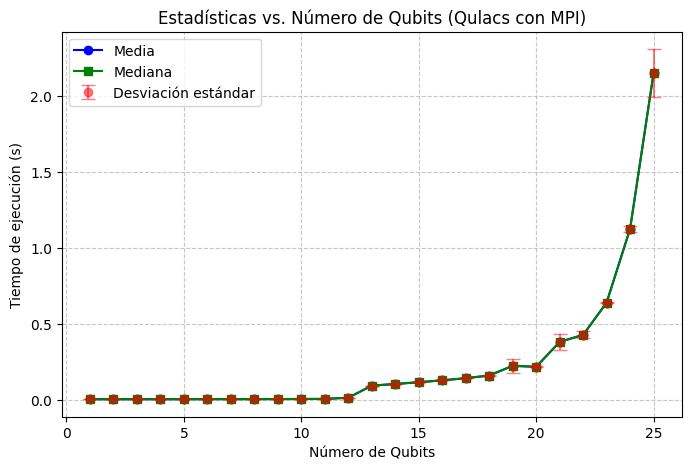

In [18]:
time_statevector_mean =  [0.004613643884658814, 0.004613339900970459, 0.004680073261260987, 0.004683852195739746, 0.004757875204086303, 0.004992818832397461, 0.005153542757034302, 0.005235350131988526, 0.0054993689060211185, 0.0062072515487670895, 0.0066074907779693605, 0.014436078071594239, 0.09388295412063599, 0.10478262901306153, 0.11634649038314819, 0.12890201210975646, 0.14287967085838318, 0.16060126423835755, 0.22423638701438903, 0.21798332333564757, 0.3815573275089264, 0.4277231693267822, 0.6404435813426972, 1.1259014904499054, 2.1506054759025575]
time_statevector_median =  [0.004613643884658814, 0.004613339900970459, 0.004680073261260987, 0.004683852195739746, 0.004757875204086303, 0.004992818832397461, 0.005153542757034302, 0.005235350131988526, 0.0054993689060211185, 0.0062072515487670895, 0.0066074907779693605, 0.014436078071594239, 0.09388295412063599, 0.10478262901306153, 0.11634649038314819, 0.12890201210975646, 0.14287967085838318, 0.16060126423835755, 0.22423638701438903, 0.21798332333564757, 0.3815573275089264, 0.4277231693267822, 0.6404435813426972, 1.1259014904499054, 2.1506054759025575]
time_statevector_std = [4.201531410217285e-05, 4.085302352905273e-05, 3.8290023803710936e-05, 4.308223724365234e-05, 4.083514213562012e-05, 5.37872314453125e-05, 5.9086084365844724e-05, 5.457401275634766e-05, 5.595088005065918e-05, 8.645057678222657e-05, 8.813738822937012e-05, 9.676218032836915e-05, 0.0003378868103027344, 0.0005738019943237304, 0.000492703914642334, 0.00047455430030822753, 0.0005236923694610596, 0.000981694459915161, 0.046719640493392944, 0.00358235239982605, 0.05106149315834045, 0.023358142375946044, 0.001112896203994751, 0.020380014181137086, 0.15642046928405762]

qubits_list = list(range(1, 25+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()

run 50 qubits impossible

### Run 3 25 pero 4 nodos  slurm-157000.out

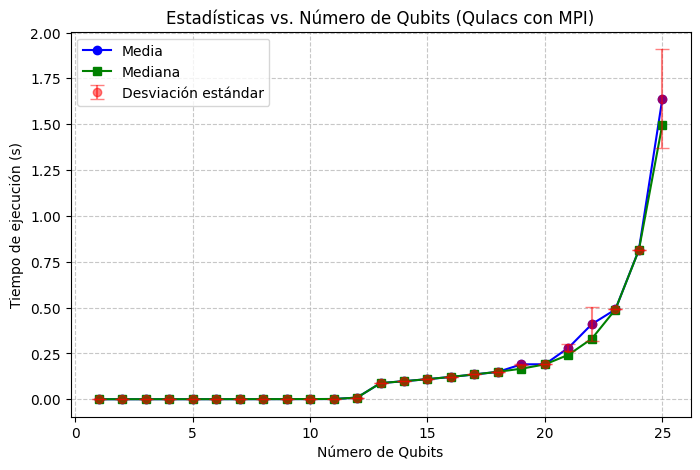

In [20]:
time_statevector_mean = [3.7622451782226565e-05, 7.369816303253174e-05, 0.00014167726039886474, 0.0002008885145187378, 0.0002603113651275635, 0.000332188606262207, 0.00041604042053222656, 0.0005230844020843506, 0.0006502270698547363, 0.0008827298879623413, 0.0012466192245483398, 0.008936741948127746, 0.08804048001766204, 0.09837363362312317, 0.10942662358283997, 0.12169020771980285, 0.13514024317264556, 0.1492316335439682, 0.1902759462594986, 0.1906529039144516, 0.2803669899702072, 0.40977480411529543, 0.48943533301353453, 0.8143696159124374, 1.6388996481895446]
time_statevector_median =  [3.693699836730957e-05, 7.32123851776123e-05, 0.00014107823371887208, 0.00019825696945190429, 0.0002596616744995117, 0.0003300189971923828, 0.0004142880439758301, 0.0005223453044891357, 0.0006491124629974365, 0.0008804738521575928, 0.0012441933155059814, 0.008934450149536134, 0.08800430297851562, 0.09841810464859009, 0.10946934223175049, 0.12184044122695922, 0.13540704250335694, 0.14958016872406005, 0.1666377604007721, 0.19008674025535582, 0.242058402299881, 0.3305787920951843, 0.4892882168292999, 0.8132292091846466, 1.4980186879634858]
time_statevector_std = [8.099476644929383e-12, 1.922195735915011e-12, 7.988099071098986e-12, 7.603251361842922e-11, 8.154188435582909e-12, 3.1517899401478644e-11, 6.273772612530592e-11, 4.8483883574590436e-11, 9.524718791453779e-11, 2.753241190589506e-10, 3.847599572281979e-10, 1.692085671578525e-08, 2.6848417205016517e-06, 2.4214927481835956e-06, 2.3343409644382974e-06, 2.8086091308665574e-06, 3.4749841768544343e-06, 1.7650027631432862e-06, 0.0037375220427998458, 5.734678086302125e-05, 0.01905000816569551, 0.09097382275072832, 5.128826536093811e-06, 8.349106834071307e-05, 0.2701101825718151]

qubits_list = list(range(1, 25+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()

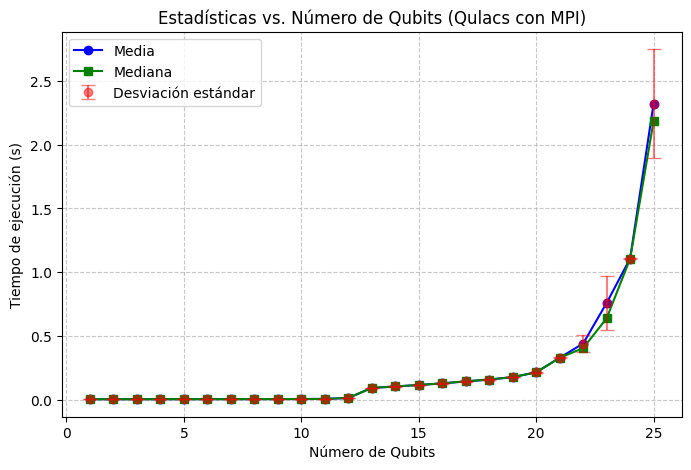

In [22]:

time_statevector_mean = [0.004621043801307678, 0.0046443849802017215, 0.004752644896507263, 0.00474134087562561, 0.004987174272537231, 0.005059584975242615, 0.005184969305992127, 0.005337244272232056, 0.005571666359901428, 0.006207609176635742, 0.006683740019798279, 0.014476576447486877, 0.09342397749423981, 0.10428760051727295, 0.11610852181911469, 0.1285521060228348, 0.14441152811050414, 0.15851730108261108, 0.17794495522975923, 0.21502240002155304, 0.3295322686433792, 0.44118024706840514, 0.758977735042572, 1.107328599691391, 2.321551325917244]
time_statevector_median =  [0.004627048969268799, 0.004637181758880615, 0.004750841856002807, 0.004733288288116455, 0.004992341995239258, 0.005059659481048584, 0.0051825642585754395, 0.005339479446411133, 0.0055590391159057615, 0.006197017431259155, 0.00668986439704895, 0.014502376317977905, 0.09343253374099732, 0.10439423322677613, 0.11622424721717835, 0.12880035042762755, 0.14463393092155458, 0.15864959359169006, 0.17809502482414247, 0.21494617462158203, 0.32906162142753603, 0.4049099564552307, 0.6382237255573273, 1.1061020374298096, 2.1849627256393434]
time_statevector_std = [0.00012750644063721112, 0.00015702636590522056, 0.00012595091807544008, 9.333170695921828e-05, 7.757814669437535e-05, 0.00010383327994519594, 8.033682700668663e-05, 8.741402954931513e-05, 8.283193340990028e-05, 9.28580915682898e-05, 7.312849118641302e-05, 0.00013917462671710401, 0.0011730187930033124, 0.001378820849219138, 0.001671990743596137, 0.0013928821350536191, 0.002539933058912747, 0.0013973575861720325, 0.001546454141165821, 0.0015911445688143032, 0.00281766828566088, 0.06556980955747184, 0.21100242102804595, 0.00537245358508298, 0.4267353210760915]


qubits_list = list(range(1, 25+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()


### Run 4 nodos 4  job 157006 mmulti_cpu = true

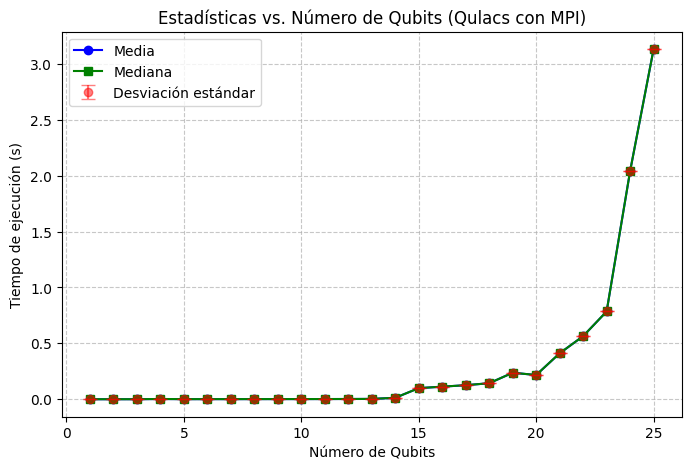

In [24]:
time_statevector_mean =  [3.733336925506592e-05, 7.372200489044189e-05, 0.00014173686504364013, 0.0019897341728210447, 0.000666499137878418, 0.0007785081863403321, 0.0008873641490936279, 0.001071077585220337, 0.0012316316366195678, 0.0012972652912139893, 0.001561671495437622, 0.0020121753215789793, 0.00281449556350708, 0.012845981121063232, 0.09912874698638915, 0.11234852075576782, 0.12539753019809724, 0.14321171045303344, 0.23686594367027283, 0.21651253700256348, 0.4107445001602173, 0.564205425977707, 0.7849364817142487, 2.04008671939373, 3.130477559566498]
time_statevector_median = [3.743171691894531e-05, 7.411837577819824e-05, 0.00014234185218811035, 0.002263045310974121, 0.000764530897140503, 0.0008796930313110351, 0.0009829401969909668, 0.0011688649654388427, 0.0013289988040924073, 0.0013940513134002685, 0.001656186580657959, 0.0021034717559814454, 0.0029127895832061768, 0.012940949201583863, 0.0992494523525238, 0.11250086426734925, 0.12547247409820556, 0.143283611536026, 0.23678970336914062, 0.21675567626953124, 0.4110128045082092, 0.5643491268157959, 0.7850137293338776, 2.0406799793243406, 3.1305313110351562]
time_statevector_std = [9.78950254193478e-13, 2.2671642341265396e-12, 7.983480543316546e-12, 1.6374518649797666e-05, 3.064184532775016e-08, 3.274806772424199e-08, 3.0358678770880944e-08, 3.216848654119531e-08, 3.243815118736393e-08, 3.163436659292529e-08, 3.2710112307654525e-08, 3.444742198155382e-08, 4.070284127521973e-08, 3.7703645716646863e-08, 6.18264682117342e-08, 2.7394651667123073e-07, 3.59165534646877e-08, 4.172185832373998e-08, 2.4160220170799106e-05, 3.705270264156013e-05, 9.500080203750371e-06, 4.1511709483188495e-07, 5.243759524375946e-08, 5.4423310125706335e-05, 5.854780003033966e-07]

qubits_list = list(range(1, 25+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()


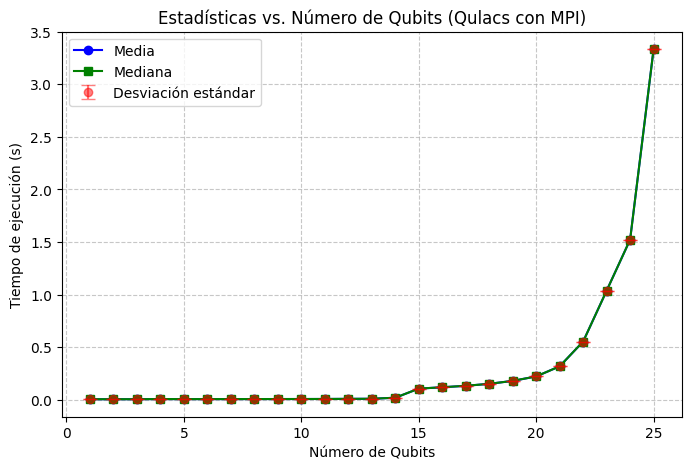

In [25]:
time_statevector_mean = [0.004546418786048889, 0.00457993745803833, 0.004635617136955261, 0.006130290031433105, 0.005360734462738037, 0.005582243204116821, 0.005675932765007019, 0.005898177623748779, 0.006216993927955628, 0.006421518325805664, 0.0067529499530792235, 0.007869851589202882, 0.008679288625717162, 0.01859966516494751, 0.10515866279602051, 0.11818788647651672, 0.131981360912323, 0.15072317719459533, 0.17879544496536254, 0.22117960155010224, 0.3172414094209671, 0.5529780805110931, 1.0366357028484345, 1.5222397923469544, 3.333679774403572]
time_statevector_median = [0.004541802406311035, 0.004558289051055908, 0.00460730791091919, 0.006217646598815918, 0.00549243688583374, 0.005707502365112305, 0.005796784162521362, 0.006031143665313721, 0.006339031457901001, 0.006545078754425049, 0.006879127025604248, 0.008008241653442383, 0.008816170692443847, 0.018746858835220336, 0.10531757473945617, 0.11835054159164429, 0.1321118414402008, 0.1508297085762024, 0.17893577218055726, 0.22132720947265624, 0.3173846900463104, 0.5531097650527954, 1.036774879693985, 1.5223759591579438, 3.333810931444168]
time_statevector_std = [0.00010072984078466364, 9.790255867014104e-05, 0.0001052555978541078, 0.0007504144991595993, 0.0002961221365351348, 0.0003304877844012961, 0.00028217143272585087, 0.00029623194266988046, 0.0002971110238068128, 0.0002728746017415596, 0.0002771430967632444, 0.00029110040146404254, 0.0002891692542131132, 0.0003089704425492556, 0.000331138441450059, 0.0004098666784713657, 0.0003708472535544178, 0.00037180893090151077, 0.00039830868438568153, 0.00042669307777926086, 0.0004287214006244976, 0.00043022876598129033, 0.0004058181858700784, 0.00041629221020221703, 0.0004038887439088316]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()



### Run 5 -- nodos 1 task per nodos 1 (Esto son los ranks)  157015

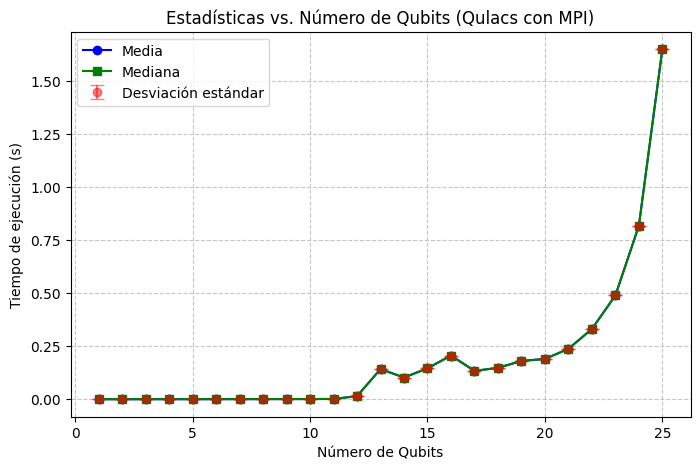

In [26]:
time_statevector_mean =  [3.8576126098632815e-05, 7.436275482177734e-05, 0.00014382600784301758, 0.0001998305320739746, 0.00026508569717407224, 0.000333869457244873, 0.00041558742523193357, 0.0005127429962158203, 0.0006480932235717774, 0.000872957706451416, 0.0012544155120849609, 0.014666450023651124, 0.14190398454666137, 0.10208990573883056, 0.1455291509628296, 0.20568782091140747, 0.1334231376647949, 0.14767303466796874, 0.18009610176086427, 0.18965784311294556, 0.23699638843536378, 0.33072651624679567, 0.48826549053192136, 0.8162327885627747, 1.6474007606506347]
time_statevector_median = [3.8576126098632815e-05, 7.436275482177734e-05, 0.00014382600784301758, 0.0001998305320739746, 0.00026508569717407224, 0.000333869457244873, 0.00041558742523193357, 0.0005127429962158203, 0.0006480932235717774, 0.000872957706451416, 0.0012544155120849609, 0.014666450023651124, 0.14190398454666137, 0.10208990573883056, 0.1455291509628296, 0.20568782091140747, 0.1334231376647949, 0.14767303466796874, 0.18009610176086427, 0.18965784311294556, 0.23699638843536378, 0.33072651624679567, 0.48826549053192136, 0.8162327885627747, 1.6474007606506347]
time_statevector_std = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()



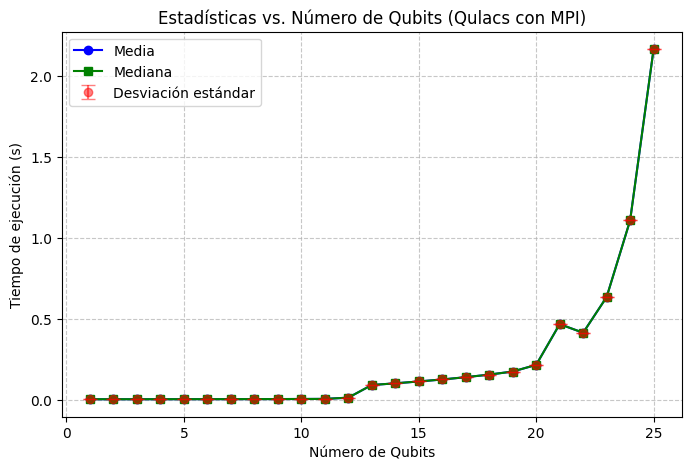

In [28]:
time_statevector_mean = [0.0046251177787780765, 0.004592800140380859, 0.0046324610710144045, 0.004721951484680176, 0.0048988938331604006, 0.004972648620605469, 0.005167913436889648, 0.005302393436431884, 0.005566537380218506, 0.0061342716217041016, 0.006587588787078857, 0.014273262023925782, 0.09230625629425049, 0.10259178876876832, 0.1141930103302002, 0.1263141632080078, 0.14048175811767577, 0.1563907265663147, 0.17540266513824462, 0.21642152070999146, 0.46766033172607424, 0.41468244791030884, 0.6347141146659852, 1.1074366331100465, 2.163592827320099]
time_statevector_median = [0.0046251177787780765, 0.004592800140380859, 0.0046324610710144045, 0.004721951484680176, 0.0048988938331604006, 0.004972648620605469, 0.005167913436889648, 0.005302393436431884, 0.005566537380218506, 0.0061342716217041016, 0.006587588787078857, 0.014273262023925782, 0.09230625629425049, 0.10259178876876832, 0.1141930103302002, 0.1263141632080078, 0.14048175811767577, 0.1563907265663147, 0.17540266513824462, 0.21642152070999146, 0.46766033172607424, 0.41468244791030884, 0.6347141146659852, 1.1074366331100465, 2.163592827320099]
time_statevector_std =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Qulacs con MPI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('quantum_autoencoder_performance.png')
plt.show()


---
# **TESTS FOR ANALYSIS**
---

### **Run 5  1 nodo 25 qubits**

*****************************************************************************
*                                                                           *
*                    JOB EFFICIENCY REPORT (seff 157257)                   *
*                                                                           *
*****************************************************************************

Job ID: 157257

Cluster: qmio

User/Group: curso189/usc

State: COMPLETED (exit code 0)

Nodes: 1

Cores per node: 48

CPU Utilized: 01:16:42

CPU Efficiency: 42.42% of 03:00:48 core-walltime

Job Wall-clock time: 00:03:46

Memory Utilized: 618.94 MB

Memory Efficiency: 2.06% of 29.30 GB

 ************************************************************************
 *  Memory Efficiency is too small. Please review the requested memory.  
 * It seems that you do not need that much memory so we recommend       
 * requesting less memory in other similar jobs.                        
 *************************************************************************

*************************************************************************


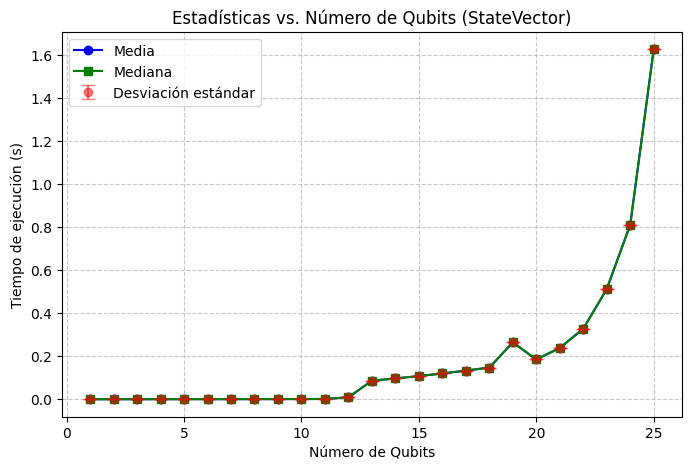

In [6]:
time_statevector_mean =  [3.8683414459228516e-05, 7.499456405639649e-05, 0.0001401185989379883, 0.00019794702529907227, 0.0002591371536254883, 0.0003391265869140625, 0.0004084587097167969, 0.0005269050598144531, 0.0006426811218261719, 0.0008861660957336426, 0.0012375712394714355, 0.008856618404388427, 0.08623356819152832, 0.09661667346954346, 0.10771846771240234, 0.11972918510437011, 0.1331695318222046, 0.1472186803817749, 0.26462277173995974, 0.18509286642074585, 0.23849538564682007, 0.3283983588218689, 0.5125646710395813, 0.8119250297546386, 1.6285017609596253]
time_statevector_median =  [3.8683414459228516e-05, 7.499456405639649e-05, 0.0001401185989379883, 0.00019794702529907227, 0.0002591371536254883, 0.0003391265869140625, 0.0004084587097167969, 0.0005269050598144531, 0.0006426811218261719, 0.0008861660957336426, 0.0012375712394714355, 0.008856618404388427, 0.08623356819152832, 0.09661667346954346, 0.10771846771240234, 0.11972918510437011, 0.1331695318222046, 0.1472186803817749, 0.26462277173995974, 0.18509286642074585, 0.23849538564682007, 0.3283983588218689, 0.5125646710395813, 0.8119250297546386, 1.6285017609596253]
time_statevector_std = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

qubits_list = list(range(1, 25+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (StateVector)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA1_STATEVECTOR_1N25Q.png')
plt.show()


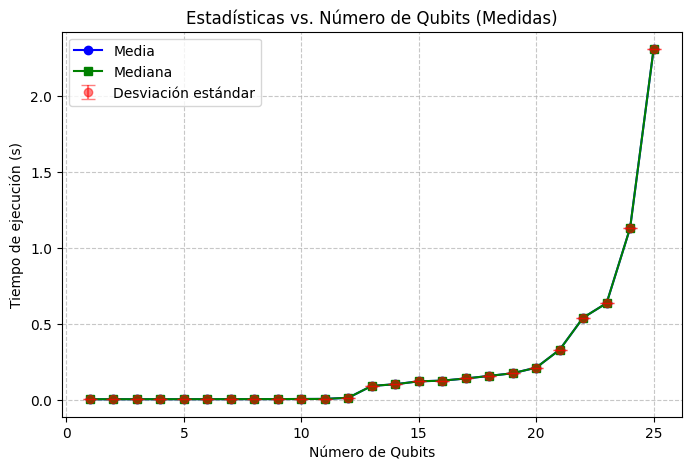

In [7]:
time_statevector_mean =  [0.004580485820770264, 0.004649960994720459, 0.004770421981811523, 0.004724609851837158, 0.004787337779998779, 0.004940783977508545, 0.005086660385131836, 0.005250120162963867, 0.005542206764221192, 0.006128048896789551, 0.006558895111083984, 0.01430356502532959, 0.09230033159255982, 0.10306512117385865, 0.1224543571472168, 0.126719331741333, 0.14099453687667846, 0.15790040493011476, 0.17553725242614746, 0.2123394012451172, 0.330178439617157, 0.5411949396133423, 0.6369452834129333, 1.1315298914909362, 2.3077094554901123]
time_statevector_median =  [0.004580485820770264, 0.004649960994720459, 0.004770421981811523, 0.004724609851837158, 0.004787337779998779, 0.004940783977508545, 0.005086660385131836, 0.005250120162963867, 0.005542206764221192, 0.006128048896789551, 0.006558895111083984, 0.01430356502532959, 0.09230033159255982, 0.10306512117385865, 0.1224543571472168, 0.126719331741333, 0.14099453687667846, 0.15790040493011476, 0.17553725242614746, 0.2123394012451172, 0.330178439617157, 0.5411949396133423, 0.6369452834129333, 1.1315298914909362, 2.3077094554901123]
time_statevector_std = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Medidas)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA1_MEASUREMENTS_1N25Q.png')
plt.show()


### **Run 6  2 nodo 25 qubits**

real    5m40.253s
user    36m53.054s
sys     4m45.586s

*****************************************************************************
*                                                                           *
*                    JOB EFFICIENCY REPORT (seff 157261)                   *
*                                                                           *
*****************************************************************************

Job ID: 157261

Cluster: qmio

User/Group: curso189/usc

State: COMPLETED (exit code 0)

Nodes: 2

Cores per node: 48

CPU Utilized: 00:41:40

CPU Efficiency: 7.59% of 09:08:48 core-walltime

Job Wall-clock time: 00:05:43

Memory Utilized: 469.75 MB

Memory Efficiency: 0.78% of 58.59 GB

 ************************************************************************
 *  Memory Efficiency is too small. Please review the requested memory.  
 * It seems that you do not need that much memory so we recommend       
 * requesting less memory in other similar jobs.                        
 *************************************************************************

*****************************************************************************

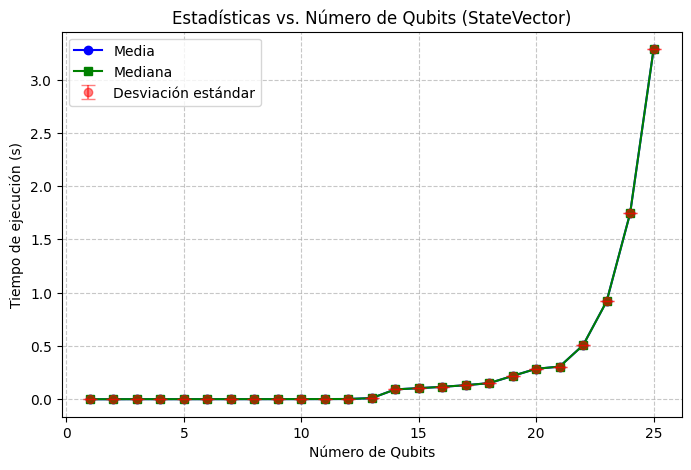

In [8]:
time_statevector_mean = [3.735423088073731e-05, 7.38382339477539e-05, 0.0007413685321807862, 0.0004626929759979248, 0.0006688833236694336, 0.0006236135959625244, 0.0007480442523956299, 0.00086747407913208, 0.0009551107883453369, 0.0011565327644348145, 0.0014940619468688965, 0.0020819544792175294, 0.01069452166557312, 0.09221689105033874, 0.103792005777359, 0.11637887358665466, 0.13167348504066467, 0.15113539695739747, 0.2188287317752838, 0.28555900454521177, 0.3063001275062561, 0.5076670050621033, 0.9181169986724853, 1.7444359183311462, 3.2846137464046476]
time_statevector_median = [3.735423088073731e-05, 7.38382339477539e-05, 0.0007413685321807862, 0.0004626929759979248, 0.0006688833236694336, 0.0006236135959625244, 0.0007480442523956299, 0.00086747407913208, 0.0009551107883453369, 0.0011565327644348145, 0.0014940619468688965, 0.0020819544792175294, 0.01069452166557312, 0.09221689105033874, 0.103792005777359, 0.11637887358665466, 0.13167348504066467, 0.15113539695739747, 0.2188287317752838, 0.28555900454521177, 0.3063001275062561, 0.5076670050621033, 0.9181169986724853, 1.7444359183311462, 3.2846137464046476]
time_statevector_std = [8.050449196161935e-13, 1.1326051208015997e-12, 2.9421165997689513e-06, 3.955354159757007e-08, 4.0309380722192145e-08, 3.4838952700511074e-08, 3.3888085937405774e-08, 3.460077522277061e-08, 3.2641023750557e-08, 3.4383064928533714e-08, 3.7876260705616004e-08, 3.605483129831555e-08, 4.073289190387186e-08, 4.8991024215183644e-08, 7.85329113739408e-08, 3.946035249668967e-08, 3.629525124893007e-08, 4.8867073587643973e-08, 3.207236887448062e-06, 2.9840366764233297e-07, 7.948402611646088e-08, 6.050141507785156e-08, 4.449475453327522e-06, 5.621569698632811e-08, 1.2713901263339266e-06]


plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (StateVector)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA2_STATEVECTOR_2N25Q.png')
plt.show()




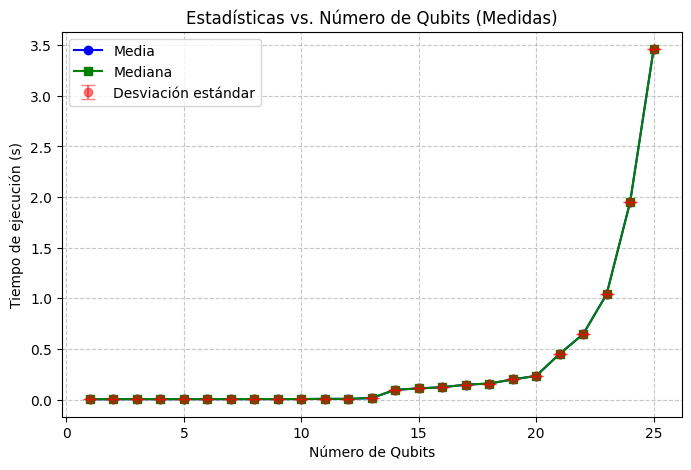

In [10]:
time_statevector_mean = [0.004598450660705566, 0.004706168174743652, 0.005637425184249878, 0.005081826448440551, 0.005167871713638306, 0.005380553007125854, 0.005565387010574341, 0.005694383382797241, 0.005894458293914795, 0.006216812133789063, 0.008227354288101197, 0.00783887505531311, 0.016513603925704955, 0.09767839312553406, 0.11138134598731994, 0.12279699444770813, 0.14812223315238954, 0.1591442584991455, 0.20017839074134827, 0.2348209798336029, 0.4527072310447693, 0.6469590425491333, 1.0412537574768066, 1.9502140939235688, 3.459108608961105]
time_statevector_median =  [0.004598450660705566, 0.004706168174743652, 0.005637425184249878, 0.005081826448440551, 0.005167871713638306, 0.005380553007125854, 0.005565387010574341, 0.005694383382797241, 0.005894458293914795, 0.006216812133789063, 0.008227354288101197, 0.00783887505531311, 0.016513603925704955, 0.09767839312553406, 0.11138134598731994, 0.12279699444770813, 0.14812223315238954, 0.1591442584991455, 0.20017839074134827, 0.2348209798336029, 0.4527072310447693, 0.6469590425491333, 1.0412537574768066, 1.9502140939235688, 3.459108608961105]
time_statevector_std = [4.2498111724853516e-05, 0.00012102127075195313, 0.0005157172679901123, 0.0002748310565948486, 0.00023085474967956542, 0.0002704203128814697, 0.00026769042015075686, 0.00026752352714538575, 0.00022071599960327148, 0.00021425485610961914, 0.0002347886562347412, 0.00021137595176696778, 0.0002316892147064209, 0.00025753378868103026, 0.0003084123134613037, 0.00023128390312194825, 0.0002386033535003662, 0.00025377273559570315, 0.00029498934745788576, 0.000282210111618042, 0.00026897192001342776, 0.0002483487129211426, 0.0002646088600158691, 0.0002481281757354736, 0.00022560954093933105]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Medidas)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA2_MEASUREMENTS_2N25Q.png')
plt.show()


### **Run 7  4 nodos 25 qubits**


*****************************************************************************
*                                                                           *
*                    JOB EFFICIENCY REPORT (seff 157264)                   *
*                                                                           *
*****************************************************************************

Job ID: 157264

Cluster: qmio

User/Group: curso189/usc

State: COMPLETED (exit code 0)

Nodes: 4

Cores per node: 48

CPU Utilized: 00:23:42

CPU Efficiency: 2.24% of 17:36:00 core-walltime

Job Wall-clock time: 00:05:30

Memory Utilized: 342.94 MB

Memory Efficiency: 0.29% of 117.19 GB

 ************************************************************************
 *  Memory Efficiency is too small. Please review the requested memory.  
 * It seems that you do not need that much memory so we recommend       
 * requesting less memory in other similar jobs.                        
 *************************************************************************

*****************************************************************************


*****************************************************************************
*                                                                           *
*                    JOB EFFICIENCY REPORT (seff 157264)                   *
*                                                                           *
*****************************************************************************

Job ID: 157264

Cluster: qmio

User/Group: curso189/usc

State: COMPLETED (exit code 0)

Nodes: 4

Cores per node: 48

CPU Utilized: 01:34:44

CPU Efficiency: 8.97% of 17:36:00 core-walltime

Job Wall-clock time: 00:05:30

Memory Utilized: 342.94 MB

Memory Efficiency: 0.29% of 117.19 GB

 ************************************************************************
 *  Memory Efficiency is too small. Please review the requested memory.  
 * It seems that you do not need that much memory so we recommend       
 * requesting less memory in other similar jobs.                        
 *************************************************************************

*****************************************************************************


*****************************************************************************
*                                                                           *
*                    JOB EFFICIENCY REPORT (seff 157264)                   *
*                                                                           *
*****************************************************************************

Job ID: 157264

Cluster: qmio

User/Group: curso189/usc

State: COMPLETED (exit code 0)

Nodes: 4

Cores per node: 48

CPU Utilized: 01:34:44

CPU Efficiency: 8.97% of 17:36:00 core-walltime

Job Wall-clock time: 00:05:30

Memory Utilized: 342.94 MB

Memory Efficiency: 0.29% of 117.19 GB

 ************************************************************************
 *  Memory Efficiency is too small. Please review the requested memory.  
 * It seems that you do not need that much memory so we recommend       
 * requesting less memory in other similar jobs.                        
 *************************************************************************

*****************************************************************************


*****************************************************************************
*                                                                           *
*                    JOB EFFICIENCY REPORT (seff 157264)                   *
*                                                                           *
*****************************************************************************

Job ID: 157264

Cluster: qmio

User/Group: curso189/usc

State: COMPLETED (exit code 0)

Nodes: 4

Cores per node: 48

CPU Utilized: 01:34:44

CPU Efficiency: 8.97% of 17:36:00 core-walltime

Job Wall-clock time: 00:05:30

Memory Utilized: 342.94 MB

Memory Efficiency: 0.29% of 117.19 GB

 ************************************************************************
 *  Memory Efficiency is too small. Please review the requested memory.  
 * It seems that you do not need that much memory so we recommend       
 * requesting less memory in other similar jobs.                        
 *************************************************************************

*****************************************************************************

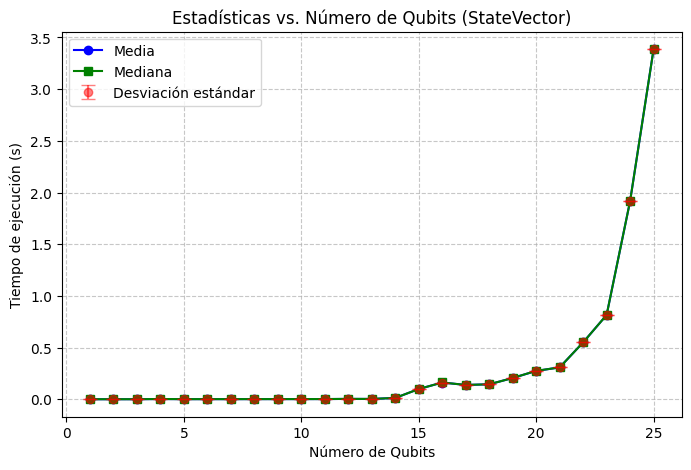

In [12]:
time_statevector_mean = [3.722012042999268e-05, 7.373988628387452e-05, 0.0001417011022567749, 0.0020201176404953, 0.0006639868021011353, 0.0007701486349105835, 0.0008766889572143554, 0.0010497897863388061, 0.001195862889289856, 0.0012848109006881713, 0.0015347272157669068, 0.0030176997184753417, 0.002746546268463135, 0.012571215629577637, 0.09851302206516266, 0.16178927421569825, 0.13809652328491212, 0.14428448379039766, 0.2053142547607422, 0.2738739579916, 0.30788652002811434, 0.5500131607055664, 0.8150175124406814, 1.9172065138816834, 3.3857883483171465]
time_statevector_median =  [3.707408905029297e-05, 7.330179214477539e-05, 0.00014031529426574706, 0.002144545316696167, 0.0007560431957244873, 0.0008615612983703613, 0.0009645521640777588, 0.0011359989643096925, 0.0012797176837921142, 0.001366591453552246, 0.0016126275062561036, 0.003423720598220825, 0.002822011709213257, 0.012649863958358765, 0.09861075282096862, 0.16183630824089051, 0.13816221356391906, 0.14435913562774658, 0.2052920162677765, 0.27449833750724795, 0.30795803666114807, 0.5500792562961578, 0.8151086330413818, 1.9177476227283479, 3.386515897512436]
time_statevector_std = [4.46753745109163e-13, 9.57331991457977e-12, 8.921769989456152e-11, 2.051464153982607e-05, 3.005360316166161e-08, 2.9370976584175424e-08, 2.733421951006676e-08, 2.776282013172704e-08, 2.6067871594648295e-08, 2.70265195112529e-08, 2.6082974891039612e-08, 1.99156010154411e-06, 2.446485645180019e-08, 3.025316033244962e-08, 4.618331193029235e-08, 2.5632805531472516e-07, 3.170377809169622e-08, 3.4281752725462414e-08, 1.370206716231337e-05, 3.140152576417421e-05, 7.369182686289832e-08, 3.51942248677517e-06, 8.015569294528291e-07, 2.6266493605575646e-05, 0.00024169264017093184]


plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (StateVector)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA3_STATEVECTOR_4N25Q.png')
plt.show()


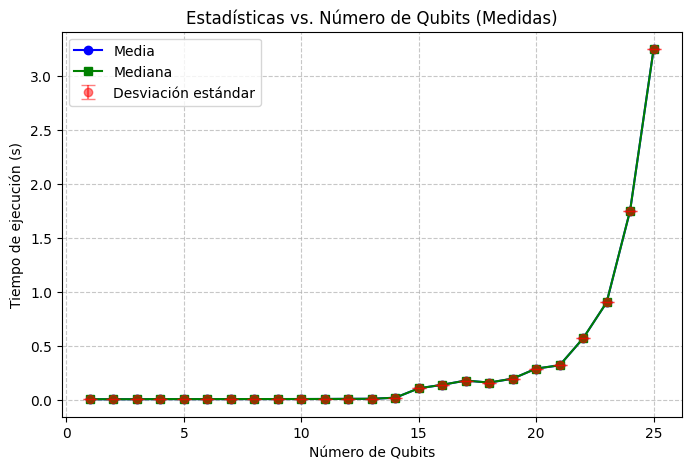

In [13]:

time_statevector_mean = [0.004663094878196716, 0.004665249586105346, 0.004722490906715393, 0.005910071730613709, 0.005375984311103821, 0.00555230975151062, 0.005719622969627381, 0.005940571427345276, 0.006146752834320068, 0.006346169114112854, 0.006709715723991394, 0.007731968164443969, 0.008551260828971863, 0.018439865112304686, 0.10554522275924683, 0.13801443874835967, 0.17744719088077546, 0.15863485932350158, 0.19516502916812897, 0.2885125488042831, 0.3188984453678131, 0.569290480017662, 0.90196413397789, 1.7535851657390595, 3.2492032557725907]
time_statevector_median =  [0.004589277505874634, 0.004615473747253418, 0.0046945691108703615, 0.005833721160888672, 0.005507272481918335, 0.005654674768447876, 0.005817997455596924, 0.006080788373947143, 0.006257599592208863, 0.006452614068984985, 0.006813591718673706, 0.007850271463394166, 0.008645778894424439, 0.018545883893966674, 0.10568667054176331, 0.1381843864917755, 0.17755228281021118, 0.15875125527381898, 0.1952961266040802, 0.28864586353302, 0.31901135444641116, 0.5694188356399537, 0.9020766258239746, 1.7537038981914521, 3.2492986798286436]
time_statevector_std = [0.00018858184686700453, 0.00014685343907932483, 0.00013242756584761118, 0.000841316239268131, 0.00031116949158654233, 0.0002799371034632463, 0.00028548125809481443, 0.00030897600812696327, 0.00025042831438253197, 0.00024398073917442716, 0.0002740451793993082, 0.00024180298474240098, 0.00023480115182387165, 0.00025948098539907557, 0.00030310512431556036, 0.00038223431138112495, 0.0002997585094923852, 0.00029629989452174826, 0.0003529466208129962, 0.0003353774546137635, 0.0003215296914237494, 0.00030914158856890344, 0.00032337594133257465, 0.00032554734148630064, 0.000314976031191496]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Medidas)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA3_MEASUREMENTS_4N25Q.png')
plt.show()

### **Run 8  16 nodos 25 qubits**  (voy a coger el ultimo report)


*****************************************************************************
*                                                                           *
*                    JOB EFFICIENCY REPORT (seff 157265)                   *
*                                                                           *
*****************************************************************************

Job ID: 157265

Cluster: qmio

User/Group: curso189/usc

State: COMPLETED (exit code 0)

Nodes: 16

Cores per node: 48

CPU Utilized: 02:21:29

CPU Efficiency: 5.61% of 1-18:01:36 core-walltime

Job Wall-clock time: 00:03:17

Memory Utilized: 229.00 MB

Memory Efficiency: 0.05% of 468.75 GB

 ************************************************************************
 *  Memory Efficiency is too small. Please review the requested memory.  
 * It seems that you do not need that much memory so we recommend       
 * requesting less memory in other similar jobs.                        
 *************************************************************************

*****************************************************************************

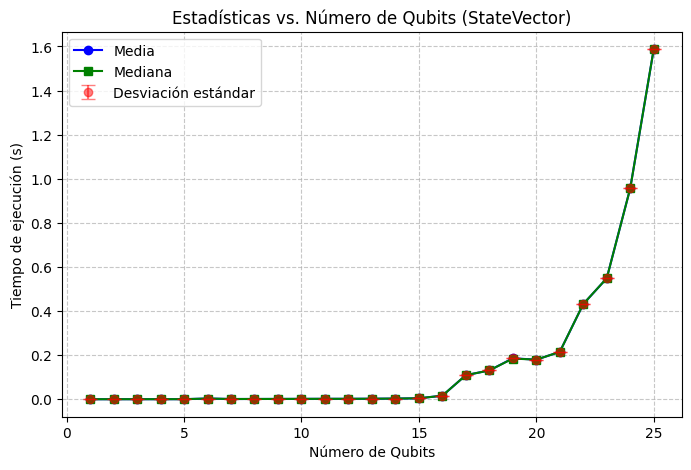

In [14]:

time_statevector_mean =  [3.733932971954346e-05, 7.518455386161804e-05, 0.00014264360070228576, 0.00019963234663009644, 0.0002626970410346985, 0.003166373074054718, 0.0009889714419841766, 0.0011417679488658905, 0.0013255923986434937, 0.001624104380607605, 0.001827964186668396, 0.0018819071352481841, 0.002255403250455856, 0.002988569438457489, 0.004259095340967178, 0.016028692573308946, 0.10910498201847077, 0.13046006336808205, 0.18562616407871246, 0.17940425947308541, 0.21462029069662095, 0.4315869465470314, 0.5483588077127933, 0.9567646265029908, 1.5864997230470181]
time_statevector_median =  [3.7217140197753905e-05, 7.387995719909668e-05, 0.00014218688011169434, 0.00019915103912353515, 0.00026197433471679686, 0.003196626901626587, 0.0010141432285308838, 0.0011667490005493164, 0.0013504266738891602, 0.0016477704048156738, 0.0018538713455200195, 0.001903867721557617, 0.00227893590927124, 0.0030090928077697752, 0.004285645484924316, 0.016056281328201295, 0.10914023518562317, 0.13049953579902648, 0.18458012938499452, 0.17939912676811218, 0.21472761034965515, 0.43195059299468996, 0.5485973715782165, 0.956243246793747, 1.5872170746326446]
time_statevector_std = [6.283640274773461e-13, 3.0035193221422676e-10, 1.4925627400685926e-11, 1.0739942268855885e-11, 2.614355398833368e-11, 8.805360466279667e-06, 9.690188684796652e-09, 9.9164061961865e-09, 9.79120768906938e-09, 1.0430672259253982e-08, 1.0073142608924001e-08, 9.987350735318756e-09, 9.816730084377668e-09, 1.2364596568836816e-08, 1.2700759677297668e-08, 1.7145168895726925e-08, 6.231746954021845e-08, 7.035102281838234e-08, 1.5994814753228503e-05, 6.924390542062397e-08, 1.6507809362131809e-06, 1.896114967010476e-05, 1.99925494215214e-05, 6.730645084429554e-05, 5.585866688305741e-05]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (StateVector)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_STATEVECTOR_16N25Q.png')
plt.show()




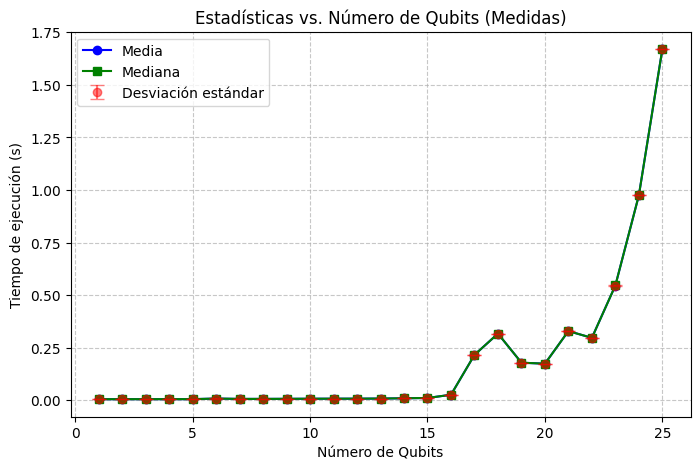

In [15]:
time_statevector_mean =  [0.004592255502939224, 0.004718782007694244, 0.004729008674621582, 0.004784842580556869, 0.004888510704040528, 0.007622824609279632, 0.005948429554700851, 0.0060470737516880035, 0.00638301894068718, 0.006807756423950195, 0.0070513270795345305, 0.007148312777280808, 0.007650361955165863, 0.008959207683801651, 0.01044788733124733, 0.025660368055105208, 0.2153889149427414, 0.3166642151772976, 0.178273493796587, 0.17351742312312127, 0.32863462939858434, 0.29640862718224525, 0.5455242075026036, 0.9744751378893852, 1.669393863528967]
time_statevector_median =  [0.00458294153213501, 0.004703068733215332, 0.004720467329025269, 0.0047728240489959715, 0.004894065856933594, 0.007724571228027344, 0.0059848248958587645, 0.006078207492828369, 0.006427353620529175, 0.006846112012863159, 0.0070914685726165775, 0.007180404663085937, 0.0076986908912658695, 0.009000104665756226, 0.010492700338363647, 0.025713473558425903, 0.2154521942138672, 0.3167168200016022, 0.17831547260284425, 0.17355839014053345, 0.3286861002445221, 0.296462082862854, 0.5455718576908112, 0.9745150327682495, 1.6694459021091461]
time_statevector_std = [9.195911722415952e-05, 0.00017788927068982096, 0.0001056528348257264, 0.00010812237832755118, 8.85798544067575e-05, 0.0007069472250674262, 0.00017469305177328327, 0.00016331605536806554, 0.00016384004591928942, 0.00017062492360408725, 0.00016601677280614265, 0.00015346182971511272, 0.00018044573687688638, 0.00016271470740077053, 0.00018669607103539732, 0.00020936457074689608, 0.00023351362779218667, 0.0002238775156029348, 0.0001895930161112653, 0.00018970529687960928, 0.00020183942970682897, 0.00021203748295819014, 0.00021654000794624242, 0.0002008466875773698, 0.00020692189708808035]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Media', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Mediana', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Desviación estándar', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Medidas)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_MEASUREMENTS_16N25Q.png')
plt.show()

# 16 nodes 33 qubits

*****************************************************************************
*                                                                           *
*                    JOB EFFICIENCY REPORT (seff 159687)                   *
*                                                                           *
*****************************************************************************

Job ID: 159687

Cluster: qmio

User/Group: curso189/usc

State: COMPLETED (exit code 0)

Nodes: 16

Cores per node: 48

CPU Utilized: 1-11:35:54

CPU Efficiency: 0.53% of 278-01:16:48 core-walltime

Job Wall-clock time: 08:41:21

Memory Utilized: 12.15 GB

Memory Efficiency: 2.59% of 468.75 GB

 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
*   Memory Efficiency is too small. Please review the requested memory. *
* It seems that you do not need that much memory so we recommend        *
* requesting less memory in other similar jobs.                         *
 *****************************************************************************

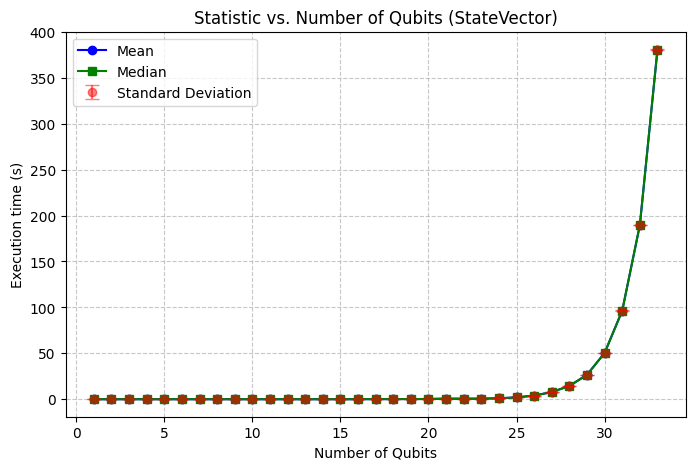

In [7]:
time_statevector_mean =  [3.7659704685211184e-05, 7.474273443222045e-05, 0.000142650306224823, 0.000199977308511734, 0.0002621367573738098, 0.003220990300178528, 0.0009801343083381652, 0.001127399504184723, 0.0013149872422218323, 0.0015952110290527344, 0.0017960511147975921, 0.0018632836639881135, 0.0022305868566036223, 0.0029646195471286774, 0.004211851954460144, 0.017091885209083557, 0.13624804541468621, 0.12467496544122696, 0.18106871843338013, 0.24833179861307145, 0.6265878573060035, 0.5273407325148582, 0.6441744603216648, 1.0454333156347275, 1.9562484249472618, 4.026973519474268, 7.771786829084158, 14.477795609086751, 26.605730164796114, 50.429089460521936, 96.46426304131747, 189.66686854362487, 380.7394620142877]
time_statevector_median =  [3.734827041625977e-05, 7.39455223083496e-05, 0.00014166831970214845, 0.00019928216934204102, 0.00026078224182128905, 0.0033333182334899904, 0.0010053455829620362, 0.0011512398719787597, 0.0013384878635406493, 0.0016184687614440919, 0.0018182218074798584, 0.0018860578536987304, 0.0022537291049957277, 0.002989774942398071, 0.004239630699157715, 0.01711680293083191, 0.13628557324409485, 0.12469545006752014, 0.18097828030586244, 0.2487179696559906, 0.6265822231769562, 0.528064352273941, 0.6439962148666382, 1.0462598860263825, 1.9563194394111634, 4.027412909269333, 7.771580773591995, 14.473820209503174, 26.606858718395234, 50.428083050251004, 96.43183448314667, 189.67226648330688, 380.76588532328606]
time_statevector_std = [3.360023370646559e-12, 1.6403989278046538e-11, 1.1166445545995884e-11, 1.5338519343544022e-11, 2.133371257428962e-11, 8.796666856514257e-06, 9.599671324522774e-09, 9.323245864223395e-09, 9.15872446771715e-09, 9.458675154228046e-09, 8.736526624364415e-09, 9.125622602024208e-09, 8.514355431810117e-09, 1.2164568630179673e-08, 1.3138958321334825e-08, 1.6289008319958497e-08, 1.7236840562984134e-06, 1.833305911524974e-08, 1.0650021944114129e-06, 2.26364008303781e-05, 0.00016261365468017708, 8.012694990093827e-05, 1.2903590313417812e-05, 7.730012923943264e-05, 5.565368390909597e-05, 0.00021976443138010948, 0.0005181874673509168, 0.006034492826945115, 0.006285930797567174, 0.04795462349557432, 0.15888237606251437, 0.2829879837404278, 0.39141687268292125]

qubits_list = list(range(1, 33+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Mean', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Median', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Standard Deviation', color='red', alpha=0.5)

plt.xlabel('Number of Qubits')
plt.ylabel('Execution time (s)')
plt.title('Statistic vs. Number of Qubits (StateVector)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_STATEVECTOR_16N33Q.png')
plt.show()


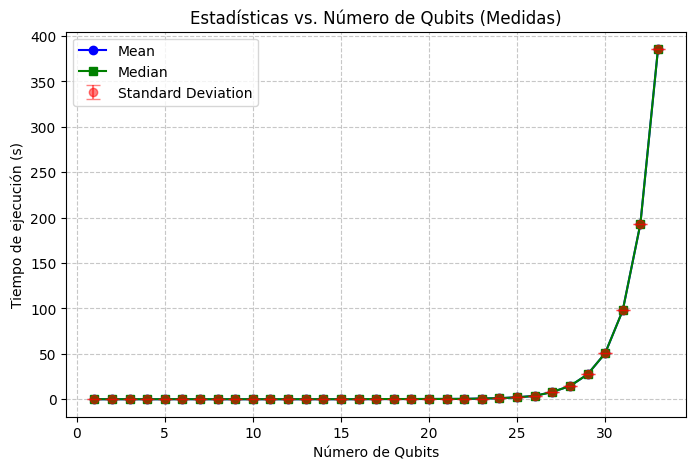

In [8]:
time_statevector_mean =  [0.004590059816837311, 0.004633887112140656, 0.004681269079446793, 0.00478154569864273, 0.004901725053787232, 0.06783383190631867, 0.005974812060594558, 0.006074678152799606, 0.006383691728115082, 0.00677093043923378, 0.00702027678489685, 0.0071427710354328156, 0.007618092745542526, 0.014065732061862946, 0.01585165038704872, 0.031338272243738176, 0.16415250152349473, 0.21094972118735314, 0.22511069774627684, 0.27108053416013717, 0.3194736286997795, 0.3839146062731743, 0.7845355130732059, 1.1201830834150315, 2.131760333478451, 3.6412041775882242, 7.984587898105383, 14.506467328220605, 27.311269944906236, 50.5891734957695, 97.87252568900585, 192.9318826340139, 385.4982140250504]
time_statevector_median =  [0.004585063457489014, 0.004620856046676636, 0.00467720627784729, 0.0047788798809051515, 0.004898989200592041, 0.06798000335693359, 0.006019711494445801, 0.006123560667037964, 0.006421083211898803, 0.006802350282669067, 0.00705571174621582, 0.0071790218353271484, 0.007654058933258057, 0.014106571674346924, 0.01588699221611023, 0.03137372732162476, 0.1641928255558014, 0.21098679900169373, 0.2251483678817749, 0.2711151480674744, 0.31951165199279785, 0.3839604377746582, 0.7845688760280609, 1.1202234148979187, 2.131797158718109, 3.641259551048279, 7.9846254765987394, 14.506513452529907, 27.311311703920364, 50.589245063066485, 97.8727232992649, 192.93224982619284, 385.49910148978233]
time_statevector_std = [8.62973829508221e-05, 0.00011570014146804037, 8.683158472974791e-05, 0.00011843501201704192, 0.00010221449395819094, 0.005553015650490395, 0.0001900745847619011, 0.00018604342054652482, 0.00016466146421553458, 0.00014969881024388284, 0.0001561165017154752, 0.00015792244784508533, 0.00015604544690673116, 0.00016828388264836076, 0.00016959431492975552, 0.00019147847985704372, 0.00020194777659569076, 0.00017508174220318826, 0.00016867082260917297, 0.0001736653886613647, 0.00017856357278905332, 0.0001825756936084228, 0.0001733239817940886, 0.0001780065237612598, 0.00018819206127759934, 0.0002056759710709133, 0.00021580703639043178, 0.00021653556730705822, 0.000243054715699938, 0.00033188750815823023, 0.0004998690133741102, 0.0008670986858613254, 0.0041218723251753575]


plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Mean', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Median', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Standard Deviation', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Medidas)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_MEASUREMENTS_16N33Q.png')
plt.show()


# 1 nodo 25 qubits Optimization level=2

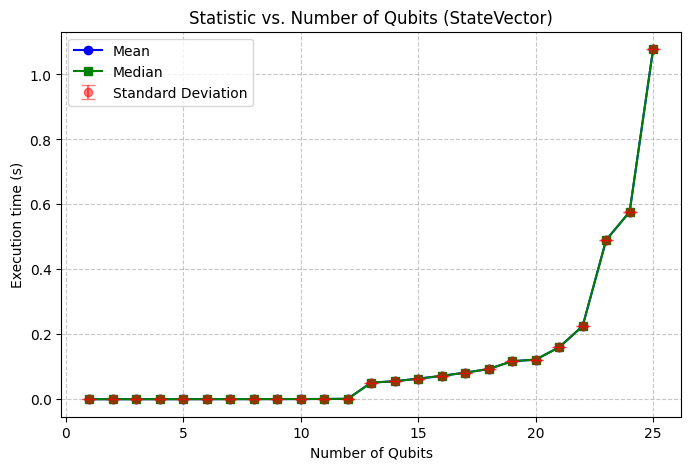

In [19]:
time_statevector_mean = [1.4173984527587891e-05, 2.6905536651611327e-05, 5.4454803466796876e-05, 9.049177169799805e-05, 0.00012753009796142578, 0.00017484426498413086, 0.00023595094680786132, 0.00029265880584716797, 0.00039347410202026365, 0.0005462288856506348, 0.0007881641387939454, 0.0013250350952148438, 0.05120494365692139, 0.0553343653678894, 0.06329708099365235, 0.07195180654525757, 0.08187462091445923, 0.09293133020401001, 0.11714061498641967, 0.12190563678741455, 0.16001328229904174, 0.22513376474380492, 0.4901897668838501, 0.5768944621086121, 1.0776859402656556]
time_statevector_median = [1.4173984527587891e-05, 2.6905536651611327e-05, 5.4454803466796876e-05, 9.049177169799805e-05, 0.00012753009796142578, 0.00017484426498413086, 0.00023595094680786132, 0.00029265880584716797, 0.00039347410202026365, 0.0005462288856506348, 0.0007881641387939454, 0.0013250350952148438, 0.05120494365692139, 0.0553343653678894, 0.06329708099365235, 0.07195180654525757, 0.08187462091445923, 0.09293133020401001, 0.11714061498641967, 0.12190563678741455, 0.16001328229904174, 0.22513376474380492, 0.4901897668838501, 0.5768944621086121, 1.0776859402656556]
time_statevector_std = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

qubits_list = list(range(1, 25+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Mean', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Median', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Standard Deviation', color='red', alpha=0.5)

plt.xlabel('Number of Qubits')
plt.ylabel('Execution time (s)')
plt.title('Statistic vs. Number of Qubits (StateVector)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_STATEVECTOR_1N25Q_optim.png')
plt.show()


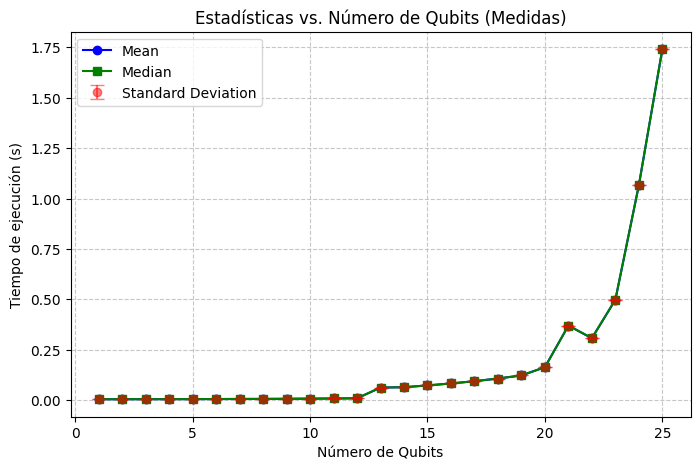

In [20]:
time_statevector_mean = [0.004802834987640381, 0.004958117008209228, 0.005087888240814209, 0.005181300640106201, 0.00542147159576416, 0.00573807954788208, 0.006117320060729981, 0.006400585174560547, 0.006907129287719726, 0.00774679183959961, 0.00839003324508667, 0.00934377908706665, 0.06259210109710693, 0.06438100337982178, 0.07322106361389161, 0.08291237354278565, 0.09422920942306519, 0.10750254392623901, 0.12272590398788452, 0.16373419761657715, 0.36996307373046877, 0.3074989438056946, 0.4981981873512268, 1.0663666248321533, 1.7407808661460877]
time_statevector_median = [0.004802834987640381, 0.004958117008209228, 0.005087888240814209, 0.005181300640106201, 0.00542147159576416, 0.00573807954788208, 0.006117320060729981, 0.006400585174560547, 0.006907129287719726, 0.00774679183959961, 0.00839003324508667, 0.00934377908706665, 0.06259210109710693, 0.06438100337982178, 0.07322106361389161, 0.08291237354278565, 0.09422920942306519, 0.10750254392623901, 0.12272590398788452, 0.16373419761657715, 0.36996307373046877, 0.3074989438056946, 0.4981981873512268, 1.0663666248321533, 1.7407808661460877]
time_statevector_std = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Mean', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Median', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Standard Deviation', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Medidas)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_MEASUREMENTS_1N25Q_optim.png')
plt.show()

# 1 nodo 25 qubits optimizacion level= 1

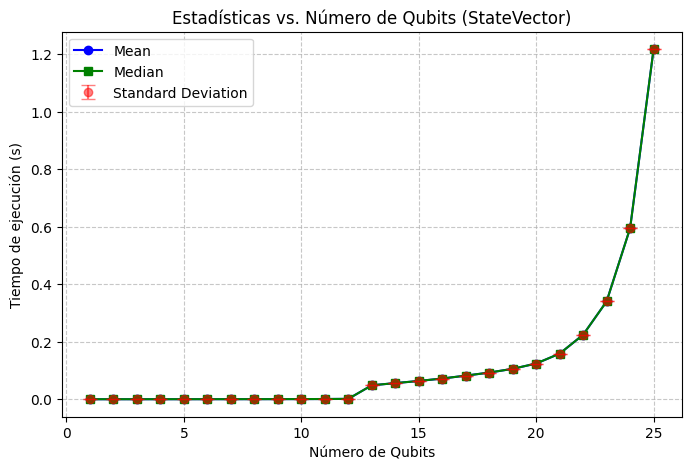

In [26]:
time_statevector_mean = [1.3148784637451172e-05, 5.273818969726562e-05, 4.965066909790039e-05, 8.014440536499023e-05, 0.00011737346649169922, 0.00015805959701538087, 0.00020966529846191406, 0.00027059316635131837, 0.0003547072410583496, 0.000494384765625, 0.0007307410240173339, 0.0012529373168945312, 0.04844363927841187, 0.05601760149002075, 0.06345539093017578, 0.0719796061515808, 0.08199158906936646, 0.0926123857498169, 0.10566707849502563, 0.12408955097198486, 0.15854986906051635, 0.22416661977767943, 0.3400114059448242, 0.5945086479187012, 1.216693651676178]
time_statevector_median = [1.3148784637451172e-05, 5.273818969726562e-05, 4.965066909790039e-05, 8.014440536499023e-05, 0.00011737346649169922, 0.00015805959701538087, 0.00020966529846191406, 0.00027059316635131837, 0.0003547072410583496, 0.000494384765625, 0.0007307410240173339, 0.0012529373168945312, 0.04844363927841187, 0.05601760149002075, 0.06345539093017578, 0.0719796061515808, 0.08199158906936646, 0.0926123857498169, 0.10566707849502563, 0.12408955097198486, 0.15854986906051635, 0.22416661977767943, 0.3400114059448242, 0.5945086479187012, 1.216693651676178]
time_statevector_std = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Mean', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Median', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Standard Deviation', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (StateVector)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_MEASUREMENTS_1N25Q_optim_1.png')
plt.show()

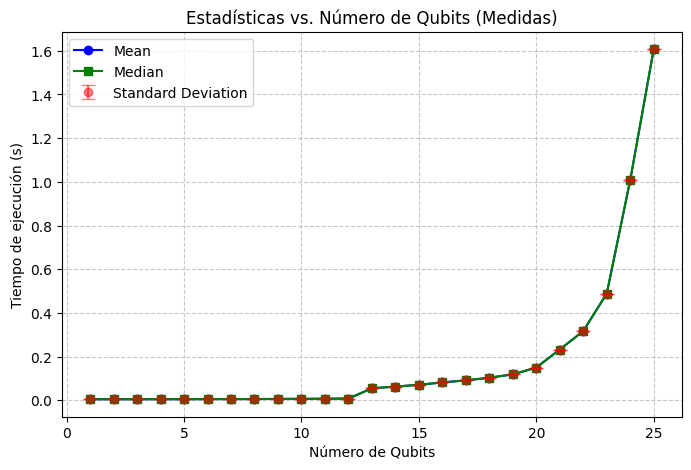

In [27]:
time_statevector_mean = [0.004849791526794434, 0.004983079433441162, 0.0049441933631896974, 0.005121195316314697, 0.005150735378265381, 0.00546039342880249, 0.00560990571975708, 0.005802440643310547, 0.006134951114654541, 0.006747734546661377, 0.007137322425842285, 0.007803404331207275, 0.05482076406478882, 0.0627288579940796, 0.0708499789237976, 0.0818328619003296, 0.0909817099571228, 0.10328774452209473, 0.11860203742980957, 0.14980190992355347, 0.23243334293365478, 0.3170293927192688, 0.48861238956451414, 1.0082525491714478, 1.6069770812988282]
time_statevector_median = [0.004849791526794434, 0.004983079433441162, 0.0049441933631896974, 0.005121195316314697, 0.005150735378265381, 0.00546039342880249, 0.00560990571975708, 0.005802440643310547, 0.006134951114654541, 0.006747734546661377, 0.007137322425842285, 0.007803404331207275, 0.05482076406478882, 0.0627288579940796, 0.0708499789237976, 0.0818328619003296, 0.0909817099571228, 0.10328774452209473, 0.11860203742980957, 0.14980190992355347, 0.23243334293365478, 0.3170293927192688, 0.48861238956451414, 1.0082525491714478, 1.6069770812988282]
time_statevector_std = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Mean', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Median', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Standard Deviation', color='red', alpha=0.5)

plt.xlabel('Número de Qubits')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Estadísticas vs. Número de Qubits (Medidas)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_MEASUREMENTS_1N25Q_optim_1.png')
plt.show()


# 8 nodos hasta 25 qubits

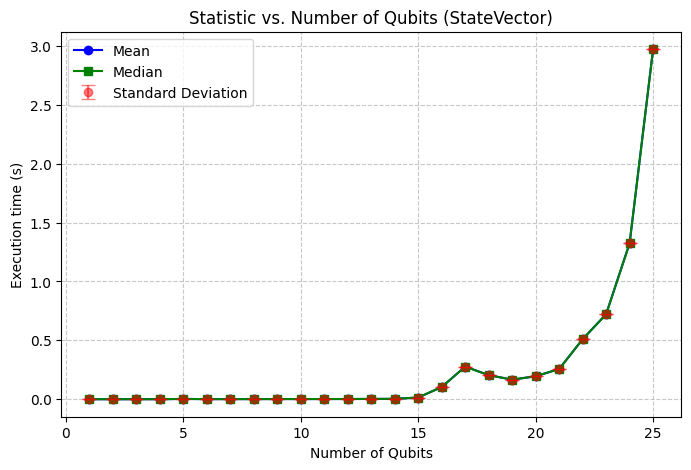

In [22]:
time_statevector_mean = [3.790855407714844e-05, 7.472187280654907e-05, 0.00014232099056243896, 0.00019955337047576903, 0.0024187356233596803, 0.0008164256811141968, 0.0009478017687797547, 0.001097606122493744, 0.0013276472687721252, 0.0014944195747375489, 0.0015614867210388184, 0.0018786922097206115, 0.002444891631603241, 0.0034237295389175416, 0.014290799200534821, 0.10372109115123748, 0.27712627649307253, 0.2045779585838318, 0.16606176644563675, 0.19511719942092895, 0.25617814511060716, 0.509562823176384, 0.7214624285697937, 1.323804460465908, 2.9706303104758263]
time_statevector_median = [3.7169456481933595e-05, 7.363557815551758e-05, 0.00014145374298095702, 0.000198519229888916, 0.0025844454765319826, 0.0008649826049804688, 0.0009955167770385742, 0.0011453509330749511, 0.0013736903667449952, 0.0015417039394378662, 0.0016048908233642577, 0.0019222676753997802, 0.0024897873401641844, 0.003459930419921875, 0.014366382360458374, 0.10376688241958618, 0.27656354308128356, 0.20429672598838805, 0.16613078713417054, 0.19516171216964723, 0.2562551498413086, 0.5099813580513001, 0.7215289533138275, 1.324133962392807, 2.9696563243865968]
time_statevector_std = [1.8971935134004525e-11, 3.8243053168685036e-11, 1.9776003057359048e-11, 1.8303047966128362e-11, 1.001320686215834e-05, 1.655845167647385e-08, 1.63428416133371e-08, 1.6362247245993443e-08, 1.6298631999589475e-08, 1.570372507586626e-08, 1.4654657043422503e-08, 1.386966723693206e-08, 1.726684479841367e-08, 1.3137186183342919e-08, 1.3366964446426266e-07, 2.928918201305919e-08, 5.754275450264856e-05, 1.350249329696851e-05, 9.210756082289607e-08, 1.4565202595751004e-05, 1.9784042044612703e-07, 2.004804052404552e-05, 3.02171558956843e-06, 7.904986232665224e-06, 0.0001601007565237733]

qubits_list = list(range(1, 25+1))

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Mean', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Median', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Standard Deviation', color='red', alpha=0.5)

plt.xlabel('Number of Qubits')
plt.ylabel('Execution time (s)')
plt.title('Statistic vs. Number of Qubits (StateVector)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_STATEVECTOR_8N25Q.png')
plt.show()

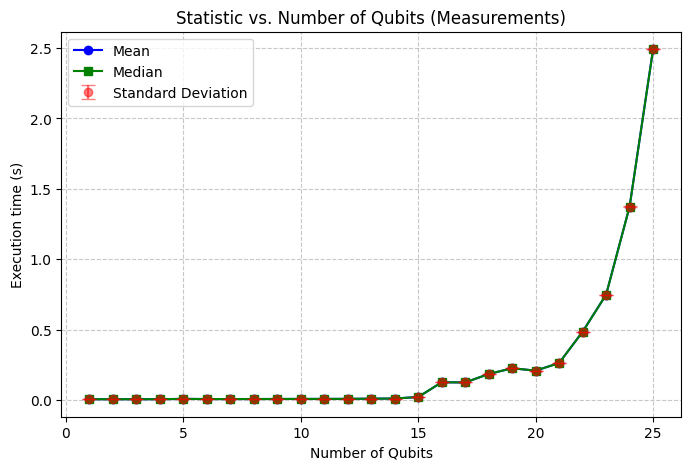

In [24]:
time_statevector_mean = [0.004605446755886078, 0.004652209579944611, 0.004743795096874237, 0.004761092364788055, 0.006986859440803528, 0.0056935325264930725, 0.005791325867176056, 0.005914822220802307, 0.0062826618552207945, 0.0065755188465118405, 0.006714202463626862, 0.007096634805202484, 0.008450175821781158, 0.00941878855228424, 0.020307810604572298, 0.12488824278116226, 0.12376166880130768, 0.1837489977478981, 0.22478983402252198, 0.2075663059949875, 0.26208449006080625, 0.48465414345264435, 0.7478263303637505, 1.3742831245064735, 2.492196886241436]
time_statevector_median = [0.004595512151718139, 0.004646342992782593, 0.004717385768890381, 0.004757094383239746, 0.007229417562484741, 0.005748951435089111, 0.00584566593170166, 0.005956315994262695, 0.006322735548019409, 0.006616348028182983, 0.006748867034912109, 0.007138103246688843, 0.008493101596832276, 0.009470725059509277, 0.02036367654800415, 0.1249327838420868, 0.12382928729057312, 0.1837809205055237, 0.22482557892799376, 0.2075965464115143, 0.26214054226875305, 0.48469812870025636, 0.7478714227676392, 1.3743169367313386, 2.4922448337078094]
time_statevector_std = [8.098314429026692e-05, 8.594206822014595e-05, 0.0001034840819318145, 7.995821766196837e-05, 0.0007450873049555467, 0.00022324524870526331, 0.00019106679641801643, 0.00016974316621712386, 0.00016885741695860004, 0.00016232194907838464, 0.0001539659762227431, 0.00015464962304976762, 0.00018327219767010544, 0.00016704524963772352, 0.00019836089795307083, 0.00020221112599447697, 0.0002190988950518686, 0.000148124902851777, 0.000163360713052482, 0.00014994480449820896, 0.00020300581202209672, 0.00016279811477935293, 0.00017557219727205498, 0.00016392231821349095, 0.00017557184968863568]

plt.figure(figsize=(8, 5))
plt.plot(qubits_list, time_statevector_mean, 'o-', label='Mean', color='blue')
plt.plot(qubits_list, time_statevector_median, 's-', label='Median', color='green')
plt.errorbar(qubits_list, time_statevector_mean, yerr=time_statevector_std, 
           fmt='o', capsize=5, label='Standard Deviation', color='red', alpha=0.5)

plt.xlabel('Number of Qubits')
plt.ylabel('Execution time (s)')
plt.title('Statistic vs. Number of Qubits (Measurements)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('PRUEBA4_MEASUREMENT_8N25Q.png')
plt.show()
